# Experiments with real data (individual patient)

This notebook reproduces Figures 5(a, b), 8 in the paper and gives the necessary output to manually create Figure 5(c). It requires output files generated by executing the scripts `scripts/therapy_compute_cf_mdps.sh` (with the `unobserved_reward=inf` option) and `scripts/therapy_experiment.sh`.

In [1]:
import os
os.chdir("../")

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import json
import matplotlib.ticker as mtick
from src import utils
from src.utils import get_fig_dim
from IPython.display import clear_output
import matplotlib.patches as patches
from src.therapy_mdp import Therapy_MDP
from scipy.stats import entropy

sns.set_theme(context='paper', style='ticks', font_scale=1)

In [3]:
width_pt = 397
palette = sns.color_palette('husl', 7)
type_dict = {
    'mdp_entropy' : float,
    'cf_entropy' : float,
    'id' : int,
    'k' : int,
    'avg_cf_outcome' : float,
    'num_of_explanations' : int
}

In [4]:
files = glob.glob("./outputs/therapy_exp*.json")

dicts = []
for fl_id, fl in enumerate(files):
    clear_output(wait=True)
    print('Reading file ' + str(fl_id+1)+'/'+str(len(files)))
    with open(fl,"r") as f:
        js = json.load(f)
        dicts.append(js)

input_df = pd.DataFrame(dicts)

Reading file 1302/1302


In [5]:
data_df = input_df.astype(type_dict) # Fix types
data_df = data_df.rename(columns={'mdp_entropy': 'Initial entropy', 'cf_entropy': 'Counterfactual entropy', 'avg_cf_outcome' : 'Average counterfactual outcome', 'num_of_explanations': 'Number of counterfactual explanations'}) # Rename columns
data_df['Normalized counterfactual outcome'] = data_df['Average counterfactual outcome']/data_df['horizon']

In the following cell, set the value of the parameter `k` for Figures 5, 8. In the paper, we present results under `k = 3`.

In [8]:
kap=3

The following cell presents all patients with an average counterfactual improvement higher than 1%.

In [ ]:
init_df = data_df[data_df['k']==0].set_index('id')
improved_df = data_df[data_df['k']==kap].set_index('id')
comp_df = init_df
comp_df['Average counterfactual improvement'] = (improved_df['Average counterfactual outcome'] - init_df['Average counterfactual outcome'])/init_df['Average counterfactual outcome']*100
# Higher than 1% improvement
comp_df[comp_df['Average counterfactual improvement']>=1]

In [10]:
data = 'data/therapy/therapy.csv'
cf_mdp_directory = 'outputs/cf_mdps/'
num_of_cf_samples = 1000
outputs = 'outputs/'
n_jobs = 1
num_of_cf_trajectories=1000
min_horizon=10
tmdp = Therapy_MDP(data_filename=data, cf_mdp_directory=cf_mdp_directory, min_horizon=min_horizon)
tmdp.initialize_MDP()
patient_IDs = tmdp.get_valid_IDs()

In the following cell, select the patient ID.

In [11]:
patient_id = 456 # Included in the Main
# patient_id = 306 # Included in the Appendix
# patient_id = 142 # Included in the Appendix
# patient_id = 373 # Included in the Appendix
# patient_id = 15 # Included in the Appendix
# patient_id = 318 # Included in the Appendix
A_real = tmdp.get_trajectory_actions(patient_id=patient_id)
S_real = tmdp.get_trajectory_states(patient_id=patient_id)
R_real = tmdp.get_trajectory_reward(patient_id=patient_id)
pi, exp_reward = tmdp.maximize(patient_id=patient_id, k=kap)

In [12]:
trajectories = []
for seed in range(1, num_of_cf_trajectories+1):
    s, _, a, r, prob = tmdp.sample_cf_trajectory(patient_id=patient_id, pi=pi, seed=seed)
    trajectories.append((a, s, r))

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


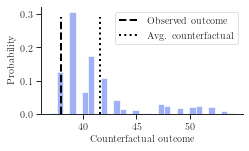

In [13]:
temp_dicts = []
for trajectory in trajectories:
    temp_dicts.append({'reward' : trajectory[2]})
temp_df = pd.DataFrame(temp_dicts)

utils.latexify(font_size=10, legend_font_size=10)

fig_height, fig_aspect = get_fig_dim(width_pt, fraction=0.65)
fig, ax = plt.subplots(figsize=(fig_height*fig_aspect,fig_height))

sns.histplot(data=temp_df, x="reward", color=palette[5], stat='probability', ax=ax)
ymax = 0.9*ax.get_ylim()[1]
ax.vlines(x=R_real,ymin=0,ymax=ymax, color='black', linestyles='dashed', linewidth=2)
ax.vlines(x=exp_reward,ymin=0,ymax=ymax, color='black', linestyles='dotted', linewidth=2)
sns.despine()

ax.legend(labels=['Observed outcome', 'Avg. counterfactual'])
ax.set_xlabel('Counterfactual outcome')

fig.tight_layout()
fig.savefig('figures/therapy_individual_{id}_k_{kap}_reward_distribution.pdf'.format(id=patient_id, kap=kap))

In [14]:
changes = np.zeros(len(A_real))
for i,_ in enumerate(changes):
    for trajectory in trajectories:
        action_trajectory = trajectory[0].tolist()
        if action_trajectory[i]!=A_real[i]:
            changes[i] += 1

weights = changes/changes.sum()
weights_dicts = []
for t,w in enumerate(weights):
    weights_dicts.append({'Time step' : t, 'weight': w, 'const': 1})
weights_df = pd.DataFrame(weights_dicts)
weights_df = weights_df.pivot('const', 'Time step', 'weight')

state_dicts = []
for t,s in enumerate(S_real):
    state_dicts.append({'Time step' : t, 'State': s, 'const': 1})
states_df = pd.DataFrame(state_dicts)
states_df = states_df.pivot('const', 'Time step', 'State')

best_reward = -np.inf
for trajectory in trajectories:
    state_trajectory = trajectory[1].tolist()
    reward = trajectory[2]
    if reward > best_reward:
        best_reward = reward
        best_trajectory = state_trajectory

sev_dicts = []
for t,s in enumerate(best_trajectory):
    sev_dicts.append({'Time step' : t, 'State': s, 'const': 1})
sev_df = pd.DataFrame(sev_dicts)
sev_df = sev_df.pivot('const', 'Time step', 'State')

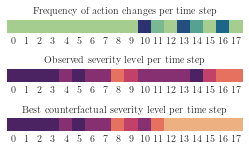

In [15]:
utils.latexify(font_size=10, legend_font_size=10)

fig_height, fig_aspect = get_fig_dim(width_pt, fraction=0.65)
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(fig_height*fig_aspect,fig_height))

sns.heatmap(weights_df, square=True, cmap=sns.color_palette("crest", as_cmap=True), ax=axes[0], cbar=False)
sns.heatmap(states_df, square=True, vmin=0, vmax=4, cmap=sns.color_palette("flare", as_cmap=True), ax=axes[1], cbar=False)
sns.heatmap(sev_df, square=True, vmin=0, vmax=4, cmap=sns.color_palette("flare", as_cmap=True), ax=axes[2], cbar=False)

axes[0].set_title('Frequency of action changes per time step')
axes[1].set_title('Observed severity level per time step')
axes[2].set_title('Best counterfactual severity level per time step')

for ax in axes:
    ax.tick_params(axis=u'both', which=u'both',length=0)
    ax.get_xaxis().label.set_visible(False)
    ax.set_yticks([])
    ax.get_yaxis().set_visible(False)

fig.tight_layout()
fig.savefig('figures/therapy_individual_{id}_k_{kap}_timestep_weights.pdf'.format(id=patient_id, kap=kap))

In [16]:
unique_counterfactuals = []
for trajectory in trajectories:
    action_trajectory = trajectory[0].tolist()
    if action_trajectory not in unique_counterfactuals:
        unique_counterfactuals.append(action_trajectory)

The following cell presents the action changes suggested by the algorithm for the specified patient.

In [26]:
print('Observed action sequence: ' + str(A_real))
print()

rewards = np.zeros(len(unique_counterfactuals))
freqs = np.zeros(len(unique_counterfactuals))
for trajectory in trajectories:
    action_trajectory = trajectory[0].tolist()
    reward = trajectory[2]
    for ind, unique in enumerate(unique_counterfactuals):
        if action_trajectory == unique:
            rewards[ind] += reward
            freqs[ind] += 1

rewards = rewards/freqs
freqs = np.around(freqs/freqs.sum()*100, decimals=1)

changes = [] 
for uniq in unique_counterfactuals:
    loc_changes = []
    for ind, a in enumerate(A_real):
        if a != uniq[ind]:
            loc_changes.append((a,uniq[ind],ind))
    changes.append(loc_changes)

for ind, ch in enumerate(changes):
    for c in ch:
        print('Replaced action ' + str(c[0]) + ' with action ' + str(c[1]) + ' at time step ' + str(c[2]))
    print('Average counterfactual reward: ' + str(rewards[ind]))
    print('Frequency: ' + str(freqs[ind]) + '%')
    print()


Observed action sequence: [0, 1, 2, 2, 2, 3, 3, 3, 3, 5, 5, 5, 4, 5, 5, 5, 9, 10]

Replaced action 5 with action 3 at time step 10
Replaced action 5 with action 3 at time step 13
Replaced action 5 with action 11 at time step 14
Average counterfactual reward: 39.0
Frequency: 30.7%

Replaced action 5 with action 3 at time step 10
Replaced action 5 with action 3 at time step 13
Replaced action 9 with action 4 at time step 16
Average counterfactual reward: 40.487329434697855
Frequency: 51.3%

Replaced action 5 with action 3 at time step 10
Replaced action 5 with action 4 at time step 11
Replaced action 9 with action 4 at time step 16
Average counterfactual reward: 48.604838709677416
Frequency: 12.4%

Replaced action 5 with action 3 at time step 10
Replaced action 5 with action 3 at time step 13
Replaced action 9 with action 5 at time step 16
Average counterfactual reward: 44.23076923076923
Frequency: 2.6%

Replaced action 5 with action 3 at time step 10
Replaced action 5 with action 4 at t